# Neural Network Learning

## Introduction

In this short lab we will go into some "hands-on" aspects of supervised learning for neural networks, based on the multi-layer perceptron trained by error back-propagation. 
There are only questions as such in the first section, a review of perceptrons. For the second part on the multi-layer perceprton you are just supposed to step through the cells, running the code, understanding why it is doing what it does, and possibly adding your own cells to experiment.

This code is for explanatory purposes only – for real neural networks you would use one of the many code libraries that exist. 

** Note: this notebook has only been tested using Python 2.**

### Acknowledgement

This lab is based on: the presentation and code accompanying Chapter 18 of "Data Science from Scratch" by J. Grus, O'Reilly Media, 2015 (all the code for the book is available [here](http://github.com/joelgrus/data-science-from-scratch)).

## Overview

In this lab we will first build a multi-layer perceptron by hand for simple Boolean functions.

The objective is to see the nuts and bolts of the representation and how the outputs of one layer are fed into the following layer.

Then we will look at a basic implementation of the back-propagation learning algorithm for a simplified version of a real-world task, characted recognition. 

To start, recall the perceptron.

## Perceptron revisited.

We will need several libraries later so it is easiest to import them first.

In [4]:
from collections import Counter
from functools import partial
import numpy as np
import math, random
import matplotlib
import matplotlib.pyplot as plt

To work with perceptrons, we will use these two functions:
"step_function(x)" which implements the thresholding, and 
"perceptron_output(weights, bias, x)" which implements the whole thresholded linear unit by calling "step_function(x)".

In [5]:
def step_function(x):
    return 1 if x >= 0 else 0 # threshold the linear unit

def perceptron_output(weights, bias, x):
    """returns 1 if the perceptron 'fires', 0 if not"""
    return step_function(np.dot(weights, x) + bias) # call step_function

Recall that the perceptron is a linear classifier with a hyperplane defined only by its weight vector. This "decision space" of this type of model is sometimes known as a *half-space*, since the classifier splits the space of points ```x``` into two half-spaces. So the model representation can just be a list of values for the weights. The perceptron implements this by a applying a step-function to the linear model ```dot(weights, x) + bias```. To illustrate, we define a two input AND gate (Boolean function).

In [6]:
# A Perceptron for two-input Boolean AND 

and_wts = [0.5,0.5] # 
and_bias = -0.8 #
and_data = [[0,0],
            [0,1],
            [1,0],
            [1,1]
           ]
for inp in and_data:
    print (perceptron_output(and_wts,and_bias,inp))

0
0
0
1


The logic of the combination of input weights and bias weight should be clear. Now go ahead and define an OR gate.

In [7]:
# A Perceptron for two-input Boolean OR 

or_wts = [0.5,0.5] # 
or_bias = -0.3 #
or_data = [[0,0],
           [0,1],
           [1,0],
           [1,1]
           ]
for inp in or_data:
    print (perceptron_output(or_wts,or_bias,inp))

0
1
1
1


What about negation ? Implement a single input NOT gate which flips a ```0``` to a ```1``` and vice versa.

In [8]:
not_wt = [-0.5] # 
not_bias = 0.3 #
not_data = [[0],
           [1]]
for inp in not_data:
    print (perceptron_output(not_wt,not_bias,inp))

1
0


All well and good, but these are simple linear threshold classifiers. However, from lectures we know that neural networks are motivated by trying to model non-linearly separable classification (as well as other more complex functions). And in the lecture we claim that the classic XOR function could be modelled by a multi-layer perceptron (MLP). Can you see how to combine our previous Boolean functions in some way to correctly model XOR ?

In [9]:
# How can you represent multiple layers of perceptrons ? Stack lists of weights!
# Suppose the MLP has two layers stacked one after the other: one hidden layer,
# and one output layer (the input "layer" will just feed into the hidden layer).
# Let's say all perceptrons in the MLP have 2 inputs and 1 bias weight. 
# We'll start by defining the input data as usual for XOR.

xor_data = [[0,0],
           [0,1],
           [1,0],
           [1,1]]

# Now we have to define the functions in each layer. Let's start with the hidden layer.
# Suppose we are told that the hidden layer will have one AND and one OR function.
# To see how these might be combined, print out the input followed by the output from 
# the AND perceptron then the OR perceptron:

for inp in xor_data:
    and_out = perceptron_output(and_wts,and_bias,inp) # perceptron_output for AND as above
    or_out = perceptron_output(or_wts,or_bias,inp) # perceptron_output for OR as above
    print (inp, and_out, or_out)

[0, 0] 0 0
[0, 1] 0 1
[1, 0] 0 1
[1, 1] 1 1


In terms of XOR, we can see that both AND and OR perceptrons are correct on the first input, both are incorrect on the last output, and only the OR perceptron is correct on the second and third inputs. Can you think of a Boolean function to correctly combine these for XOR ?

In [10]:
# By inspection, this logical function will do the job: (NOT AND) AND (OR).
# So to implement our output layer perceptron we just have to come up with a set of weights.
# We can re-use some of the weight combination ideas from our previous Boolean functions:

xor_output_wts = [-0.5,0.5] # 
xor_output_bias = -0.3 # 

xor_hidden_data = [[0,0],
                  [0,1],
                  [1,0],
                  [1,1]]

for inp in xor_hidden_data:
    print (inp, perceptron_output(xor_output_wts,xor_output_bias,inp))

[0, 0] 0
[0, 1] 1
[1, 0] 0
[1, 1] 0


Great! So, now we have all the components we need to implement multilayer perceptron for XOR, and it's just a matter of putting them all together. Go ahead and do that.

In [11]:
for inp in xor_data:
    and_out = perceptron_output(and_wts,and_bias,inp) # perceptron_output for AND as above
    or_out = perceptron_output(or_wts,or_bias,inp) #  perceptron_output for OR as above
    xor_inp = [and_out,or_out] 
    print (inp, xor_inp, perceptron_output(xor_output_wts,xor_output_bias,xor_inp))

[0, 0] [0, 0] 0
[0, 1] [0, 1] 1
[1, 0] [0, 1] 1
[1, 1] [1, 1] 0


That works, although it's pretty clunky, and it should now be very clear that you never want 
to program a neural net by hand. So how can we set it up to learn ? Well, in the lecture we note that one necessary step is to move from the perceptron's step activation function to an alternative that will allow a differentiable error function of the output. For this we will use a ** sigmoid ** function. 

Now you should implement it in a function called "neuron_output(weights, inputs)" that will return the output of the sigmoid function applied to the dot product of the neuron's weight vector (plus bias) and the input vector.

In [12]:

def sigmoid(t):
    return 1 / (1 + math.exp(-t)) # a "smoothed" version of the perceptron's step-function

def neuron_output(weights, inputs):
    return sigmoid(np.dot(weights, inputs)) # applying a sigmoid to a linear model

So now we can set up the layers of weights for the MLP to compute XOR.
This will be as a list of lists of lists of weights.
To simplify, we will combine the weights and the bias (as in homogeneous coordinates).
Let's set it up.

In [13]:
# So now we can set up the layers of weights for the MLP to compute XOR.
# To simplify, combine the weights and the bias (as in homogeneous coordinates).
# Let's set it up. We will also make a cleaner representation of the weights.

xor_network = [ # hidden layer 
    [[20, 20, -30],
    [20, 20, -10]], 
    # output layer
    [[-60, 60, -30]]]

# Note: we boost the size of the weights to force outputs close to 0 or 1 from the sigmoid.
# But the functions are the same as before.


Now we can define the feedforward stage for the MLP. It should take a network as specified and an input vector, and return values for all nodes in the output layer.

In [14]:
def feed_forward(neural_network, input_vector):
    """takes in a neural network (represented as a list of lists of lists of weights) and returns the output from forward-propagating the input"""

    outputs = []

    for layer in neural_network:

        input_with_bias = input_vector + [1]             # add a bias input
        output = [neuron_output(neuron, input_with_bias) # compute the output
                  for neuron in layer]                   # for this layer
        outputs.append(output)                           # and remember it

        # the input to the next layer is the output of this one
        input_vector = output

    return outputs

Try running this on XOR:

In [15]:
for x in[0,1]: 
    for y in[0,1]:
        print (x, y, feed_forward(xor_network,[x, y])[-1])


0 0 [9.38314668300676e-14]
0 1 [0.9999999999999059]
1 0 [0.9999999999999059]
1 1 [9.383146683006828e-14]


Here we can finally implement the backpropagation algorithm. We could directly use the algorithm from the lecture here. However, this version is essentially identical, apart from some changes of sign. You can see the steps propagating error back from the outputs to through the hidden layer.

In [16]:
def backpropagate(network, input_vector, target):

    hidden_outputs, outputs = feed_forward(network, input_vector)

    # the output * (1 - output) is from the derivative of sigmoid
    output_deltas = [output * (1 - output) * (output - target[i])
                     for i, output in enumerate(outputs)]

    # adjust weights for output layer (network[-1])
    for i, output_neuron in enumerate(network[-1]):
        for j, hidden_output in enumerate(hidden_outputs + [1]):
            output_neuron[j] -= output_deltas[i] * hidden_output

    # back-propagate errors to hidden layer
    hidden_deltas = [hidden_output * (1 - hidden_output) *
                      np.dot(output_deltas, [n[i] for n in network[-1]])
                     for i, hidden_output in enumerate(hidden_outputs)]

    # adjust weights for hidden layer (network[0])
    for i, hidden_neuron in enumerate(network[0]):
        for j, input in enumerate(input_vector + [1]):
            hidden_neuron[j] -= hidden_deltas[i] * input


## Example application: simplified hand-written digit classification

Below is the complete implementation of the algortihm. Now we will see how to apply it to some simplified "hand-written" digits for classification in to one of ten classes.

The inputs will be a 5x5 matrix of binary pixels (0 or 1, represented pictorially as '.' or '1' for input and '.' or '@' for output).

The network structure will be:

25 inputs (pixels)

5 hidden units

10 output units.

The output unit with the largest value will taken as the predicted digit.

Run the network for 10000 iterations (** this can take a few minutes**). What do you see on the output?

What about the two example inputs?

In [30]:
from collections import Counter
from functools import partial
import numpy as np
import math, random
import matplotlib
import matplotlib.pyplot as plt

def step_function(x):
    return 1 if x >= 0 else 0

def perceptron_output(weights, bias, x):
    """returns 1 if the perceptron 'fires', 0 if not"""
    return step_function(np.dot(weights, x) + bias)

def sigmoid(t):
    return 1 / (1 + math.exp(-t))

def neuron_output(weights, inputs):
    return sigmoid(np.dot(weights, inputs))

def feed_forward(neural_network, input_vector):
    """takes in a neural network (represented as a list of lists of lists of weights) and returns the output from forward-propagating the input"""

    outputs = []

    for layer in neural_network:

        input_with_bias = input_vector + [1]             # add a bias input
        output = [neuron_output(neuron, input_with_bias) # compute the output
                  for neuron in layer]                   # for this layer
        outputs.append(output)                           # and remember it

        # the input to the next layer is the output of this one
        input_vector = output

    return outputs

def backpropagate(network, input_vector, target):

    hidden_outputs, outputs = feed_forward(network, input_vector)

    # the output * (1 - output) is from the derivative of sigmoid
    output_deltas = [output * (1 - output) * (output - target[i])
                     for i, output in enumerate(outputs)]

    # adjust weights for output layer (network[-1])
    for i, output_neuron in enumerate(network[-1]):
        for j, hidden_output in enumerate(hidden_outputs + [1]):
            output_neuron[j] -= output_deltas[i] * hidden_output

    # back-propagate errors to hidden layer
    hidden_deltas = [hidden_output * (1 - hidden_output) *
                      np.dot(output_deltas, [n[i] for n in network[-1]])
                     for i, hidden_output in enumerate(hidden_outputs)]

    # adjust weights for hidden layer (network[0])
    for i, hidden_neuron in enumerate(network[0]):
        for j, input in enumerate(input_vector + [1]):
            hidden_neuron[j] -= hidden_deltas[i] * input

def patch(x, y, hatch, color):
    """return a matplotlib 'patch' object with the specified location, crosshatch pattern, and color"""
    return matplotlib.patches.Rectangle((x - 0.5, y - 0.5), 1, 1,
                                        hatch=hatch, fill=False,
color=color)


def show_weights(neuron_idx):
    weights = network[0][neuron_idx]
    abs_weights = list(map(abs, weights))
    grid = [abs_weights[row:(row+5)] # turn the weights into a 5x5 grid
            for row in range(0,25,5)] # [weights[0:5], ..., weights[20:25]]

    ax = plt.gca() # to use hatching, we'll need the axis

    ax.imshow(grid, # here same as plt.imshow
              cmap=matplotlib.cm.binary, # use white-black color scale
              interpolation='none') # plot blocks as blocks

    # cross-hatch the negative weights
    for i in range(5): # row
        for j in range(5): # column
            if weights[5*i + j] < 0: # row i, column j = weights[5*i + j]
                # add black and white hatches, so visible whether dark or
                # light
                ax.add_patch(patch(j, i, '/', "white"))
                ax.add_patch(patch(j, i, '\\', "black"))
    plt.show()
    
    # following is a list of input "images" of digits, from '0' to '9'

if __name__ == "__main__":

    raw_digits = [
          """11111
             1...1
             1...1
             1...1
             11111""",

          """..1..
             ..1..
             ..1..
             ..1..
             ..1..""",

          """11111
             ....1
             11111
             1....
             11111""",

          """11111
             ....1
             11111
             ....1
             11111""",

          """1...1
             1...1
             11111
             ....1
             ....1""",

          """11111
             1....
             11111
             ....1
             11111""",

          """11111
             1....
             11111
             1...1
             11111""",

          """11111
             ....1
             ....1
             ....1
             ....1""",

          """11111
             1...1
             11111
             1...1
             11111""",

          """11111
             1...1
             11111
             ....1
             11111"""]
    
    def make_digit(raw_digit):
        return [1 if c == '1' else 0
                for row in raw_digit.split("\n")
                for c in row.strip()]

    inputs = map(make_digit, raw_digits)

    targets = [[1 if i == j else 0 for i in range(10)]
               for j in range(10)]

    random.seed(0)   # to get repeatable results
    input_size = 25  # each input is a vector of length 25
    num_hidden = 5   # we'll have 5 neurons in the hidden layer
    output_size = 10 # we need 10 outputs for each input

    # each hidden neuron has one weight per input, plus a bias weight
    hidden_layer = [[random.random() for __ in range(input_size + 1)]
                    for __ in range(num_hidden)]

    # each output neuron has one weight per hidden neuron, plus a bias
    # weight
    output_layer = [[random.random() for __ in range(num_hidden + 1)]
                    for __ in range(output_size)]

    # the network starts out with random weights
    network = [hidden_layer, output_layer]

    # 10,000 iterations seems enough to converge
    data=zip(inputs, targets)
    print(list(data))
    for __ in range(10000):
        for input_vector, target_vector in data:
            backpropagate(network, input_vector, target_vector)

    def predict(input):
        return feed_forward(network, input)[-1]    # last element of outputs

    for i, input in enumerate(inputs):
        outputs = predict(input)
        print (i, [round(p,2) for p in outputs])

    print()
    
    print (""".@@@.
...@@
..@@.
...@@
.@@@.""")
    # This is supposed to be a '3' - check the predicted output: is it 3 ? 
    print ([round(x, 2) for x in
          predict(  [0,1,1,1,0,  # .@@@.
                     0,0,0,1,1,  # ...@@
                     0,0,1,1,0,  # ..@@.
                     0,0,0,1,1,  # ...@@
                     0,1,1,1,0]) # .@@@.
          ])
    print()

    print (""".@@@.
@..@@
.@@@.
@..@@
.@@@.""")
    # This is supposed to be an '8' - check the output: what is the prediction ?
    print ([round(x, 2) for x in
          predict(  [0,1,1,1,0,  # .@@@.
                     1,0,0,1,1,  # @..@@
                     0,1,1,1,0,  # .@@@.
                     1,0,0,1,1,  # @..@@
                     0,1,1,1,0]) # .@@@.
          ])
    print()
    

[([1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]), ([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]), ([1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]), ([1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]), ([1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]), ([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]), ([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]), ([1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]), ([1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]), 

Above you can see the 10 outputs of the network for each of the digit images. Since this is the training data, you should not be surprised to see perfect classification.

You can also look at the output that would be generated by digits that are not close to the original training data, specifically the output for the images of the '3' and the '8' that are varied from the inputs. Although the 3 is correctly classified, the network has some doubt about the '8'!

You can inspect the network weights for the hidden layer by plotting a mapping of their values onto a 5x5 input grid, representing the strength of connection on the edges from the input pixels to the output of this hidden unit. In this representation:

dark pixels $\rightarrow$ weights far from zero

white pixels $\rightarrow$ weights are zero

cross-hatching represents negative weights

In this way we can check the hidden neurons to see if they have learned any possibly useful features.

Call ```show_weights(Index)```, where ```Index``` picks out the neuron. 

You can also check the "bias" weight for each set of connections of inputs to the hidden neuron by printing out the actual value of the network weight.


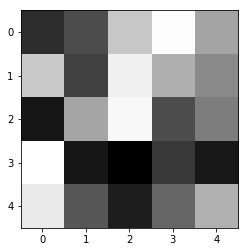

In [21]:
show_weights(0)

The first hidden neuron has some large positive weights in the leftmost column, and the middle row.

In [24]:
print (network[0][0][25])

0.09000437651779121


This looks like quite a large *negative* bias weight value, which can be interpreted as the network needing to see most or all of the inputs for which it has positive weights present in the input image before this hidden neuron will fire. 

See for yourself what the other four hidden neurons seem to be "looking for" in the input.

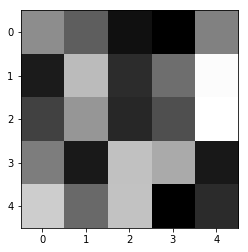

In [25]:
show_weights(1)

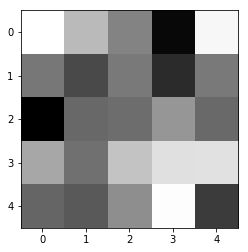

In [26]:
show_weights(2)

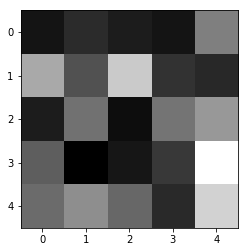

In [27]:
show_weights(3)

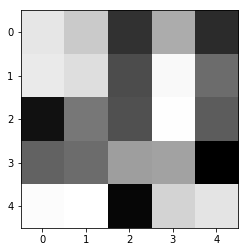

In [28]:
show_weights(4)